<a href="https://colab.research.google.com/github/ytg000629/NLP/blob/main/week5/LSTM%20%EB%84%A4%EC%9D%B4%EB%B2%84_%EC%98%81%ED%99%94%EB%A6%AC%EB%B7%B0_%EA%B0%90%EC%84%B1_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 네이버 영화 리뷰 감성 분류

## 데이터 전처리

In [2]:
pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
#데이터 로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')




In [8]:
train_data = train_data[:2000]
test_data = test_data[:500]
print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력
print('테스트용 리뷰 개수 :',len(test_data)) # 테스트용 리뷰 개수 출력
#시간 오래 걸려서 일부만 사용

훈련용 리뷰 개수 : 2000
테스트용 리뷰 개수 : 500


In [9]:
train_data.head() #0:부정 , 1: 긍정

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 중복제거, null 값 제거

In [10]:
#중복 데이터 전처리
train_data['document'].nunique() #중복데이터 존재

1993

In [11]:
#중복제거
train_data.drop_duplicates(subset=['document'], inplace=True) #중복 제거
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 1993


In [12]:
#train 데이터 레이블 값의 분포 확인
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0   1010
1      1    983


In [13]:
#null 값 확인
print(train_data.isnull().values.any()) #true가 나오면 null값 존재
print(train_data.isnull().sum()) # document 열에서 1개 존재

False
id          0
document    0
label       0
dtype: int64


In [14]:
train_data.loc[train_data.document.isnull()] # null값 샘플 인덱스 확인

,id,document,label


In [15]:
# Null 값을 가진 샘플을 제거
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


### document 칼럼 정제

In [16]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")# 한글과 공백을 제외하고 모두 제거
# [^xy] : not 을 표현하며  x 및 y 를 제외한 문자를 의미한다.
train_data

<ipython-input-16-152023bd78e6>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")# 한글과 공백을 제외하고 모두 제거


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1
...,...,...,...
1995,9840375,이런걸 우리나라에서 왜 개봉함,0
1996,4366451,출연한 배우들이 지금 보면 부끄러워할 만한 영화,0
1997,3227818,뮤직비됴 짜집기가따로없는 영화과학년생 실습작품이라해도 이보다 쓰레기일수없다,0
1998,8126237,만표로 무슨 대국민 투표라고 사기를 치고 어휴 박시환 가는거 생각만 해도 끔찍하다,0


In [17]:
print(train_data.isnull().sum())

id          0
document    0
label       0
dtype: int64


In [18]:
# 정규표현식으로 한글만 골랐기 때문에 기존에 한글이 없는 리뷰였다면 이제 더 이상 아무런 값도 없는 빈(empty) 값이 됨
# data에 공백(white space)만 있거나 빈 값을 가진 행이 있다면 Null 값으로 변경
train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
# ^x : 문자열의 시작을 표현하며 x 문자로 시작됨을 의미한다.
# x+ : 반복을 표현하며 x 문자가 한번 이상 반복됨을 의미한다.
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

id           0
document    11
label        0
dtype: int64


<ipython-input-18-8ecb70aa5053>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경


In [19]:
#null값 제거

train_data = train_data.dropna(how = 'any') # Null 샘플 제거
print(len(train_data))


1982


In [20]:
#test data에서도 똑같이
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 496


<ipython-input-20-97249adecf5b>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
<ipython-input-20-97249adecf5b>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경


### 토큰화

In [21]:
#불용어
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [22]:
#형태소분석
okt = Okt()

X_train = []  
for sentence in train_data['document']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화 #stem = True 일정 수준의 정규화 수행 ex)이런 -> 이렇다
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

X_test = []
for sentence in test_data['document']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

In [23]:
#정수 인코딩
# 훈련 데이터에 대해서 단어 집합(vocaburary) 만들기
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
# 각 단어에 고유한 정수가 부여
print(tokenizer.word_index)

{'영화': 1, '보다': 2, '을': 3, '없다': 4, '이다': 5, '있다': 6, '만': 7, '좋다': 8, '다': 9, '정말': 10, '재밌다': 11, '적': 12, '되다': 13, '같다': 14, '너무': 15, '진짜': 16, '점': 17, '나오다': 18, '아니다': 19, '연기': 20, '인': 21, '로': 22, '에서': 23, '않다': 24, '평점': 25, '안': 26, '최고': 27, '것': 28, '나': 29, '사람': 30, '내': 31, '만들다': 32, '말': 33, '드라마': 34, '보고': 35, '못': 36, '생각': 37, '그': 38, '감동': 39, '왜': 40, 'ㅋㅋ': 41, '배우': 42, '고': 43, '재미없다': 44, '하고': 45, '아깝다': 46, '재미': 47, '스토리': 48, '그냥': 49, '내용': 50, '감독': 51, '거': 52, '아': 53, '게': 54, '재미있다': 55, '때': 56, '시간': 57, '더': 58, '가다': 59, '요': 60, '그렇다': 61, '쓰레기': 62, '중': 63, '모르다': 64, '이렇다': 65, '사랑': 66, '까지': 67, '들다': 68, '주다': 69, '알다': 70, '볼': 71, '지루하다': 72, '지': 73, '싶다': 74, 'ㅋㅋㅋ': 75, '완전': 76, '주인공': 77, '작품': 78, '뭐': 79, '자다': 80, '하나': 81, '액션': 82, '정도': 83, '기': 84, 'ㅠㅠ': 85, '넘다': 86, '돈': 87, '네': 88, '이건': 89, '수': 90, '또': 91, '차다': 92, '듯': 93, '느낌': 94, '년': 95, 'ㅋ': 96, '라': 97, '최악': 98, '난': 99, '하': 100, '이렇게': 101, '일': 102, '개'

In [24]:
#빈도수가 낮은 단어 정리

threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 1336


In [25]:
tokenizer = Tokenizer(vocab_size) 
# 케라스 토크나이저는 텍스트 시퀀스를 숫자 시퀀스로 변환한다.
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [26]:
print(X_train[:3])

[[53, 433, 16, 186, 651], [652, 270, 35, 988, 1, 136, 789, 20, 989, 555, 24], [292, 990, 2, 350, 9]]


In [27]:
# data에서 y_train과 y_test를 별도로 저장
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])
     
     

리뷰의 최대 길이 : 42
리뷰의 평균 길이 : 8.646821392532795


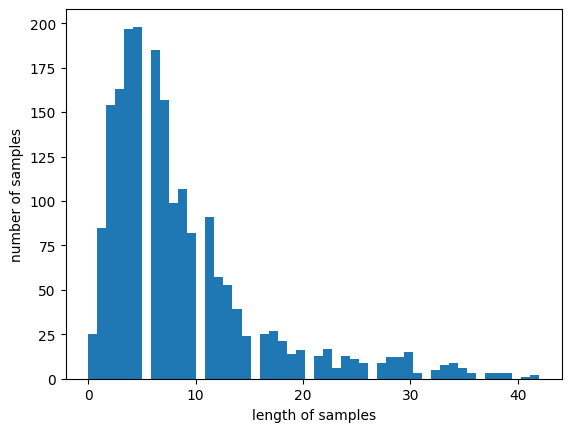

In [28]:
# 패딩
# 패딩을 위해 전체 데이터에서 가장 길이가 긴 리뷰와 전체 데이터의 길이 분포를 알아본다.

print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()
     

In [29]:
# 대부분의 리뷰가 내용이 잘리지 않도록 전체 샘플 중 길이가 max_len 이하인 샘플의 비율이 몇 %인지 확인하는 함수를 만들어 사용한다.

def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

# max_len을 30으로 지정하고 그 분포를 확인해보자.
max_len = 30
below_threshold_len(max_len, X_train)
# 전체 훈련 데이터 중 약 97%의 리뷰가 30이하의 길이를 가지는 것을 확인했다. 

전체 샘플 중 길이가 30 이하인 샘플의 비율: 97.67911200807265


In [30]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

### LSTM으로 네이버 영화리뷰 감성 분류

In [31]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [32]:
model = Sequential() #케라스의 Sequential모델 : 레이어를 선형으로 연결
model.add(Embedding(vocab_size, 100)) #첫번째 인자 : 단어 사전의 크기, 임베딩의 차원
model.add(LSTM(128)) #batch_size, input_length, input_dim) 여기서는 batch_size가 128
model.add(Dense(1, activation='sigmoid'))

# model = Sequential([
#     Embedding(vocab_size, 100),
#     LSTM(128),
#     Dense(1. activation='sigmoid')
# ])

In [33]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4) #4 에포크는 기다리고 종료
# 검증 데이터 손실(val_loss)이 증가하면 조기 종료
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
# 훈련 과정에서 검증 데이터의 정확도가 가장 높은 모델 저장

In [34]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc']) #학습방식에 대한 환경설정
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=100, validation_split=0.2)
# 훈련 데이터 중 20%를 검증 데이터로 사용하면서 정확도 확인

#0.5290 부터 4번은 loss가 상승했음 그래서 멈춤


Epoch 1/15
16/16 [==============================] - ETA: 0s - loss: 0.6924 - acc: 0.5199
Epoch 1: val_acc improved from -inf to 0.58690, saving model to best_model.h5
16/16 [==============================] - 12s 201ms/step - loss: 0.6924 - acc: 0.5199 - val_loss: 0.6908 - val_acc: 0.5869
Epoch 2/15
16/16 [==============================] - ETA: 0s - loss: 0.6877 - acc: 0.6202
Epoch 2: val_acc improved from 0.58690 to 0.68010, saving model to best_model.h5
16/16 [==============================] - 2s 141ms/step - loss: 0.6877 - acc: 0.6202 - val_loss: 0.6843 - val_acc: 0.6801
Epoch 3/15
16/16 [==============================] - ETA: 0s - loss: 0.6696 - acc: 0.6953
Epoch 3: val_acc did not improve from 0.68010
16/16 [==============================] - 2s 115ms/step - loss: 0.6696 - acc: 0.6953 - val_loss: 0.6626 - val_acc: 0.5718
Epoch 4/15
16/16 [==============================] - ETA: 0s - loss: 0.6220 - acc: 0.6997
Epoch 4: val_acc improved from 0.68010 to 0.69521, saving model to best_mod

### 리뷰 예측하기

In [35]:
def sentiment_predict(new_sentence):
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [36]:
sentiment_predict('영화의 주제가 뭔지 모르겠음')

1/1 [==============================] - 0s 368ms/step
93.02% 확률로 부정 리뷰입니다.



In [37]:
sentiment_predict('기대보다는 스토리가 큰 감흥은 없습니다 연기는 잔잔하게 볼 만 합니다')

1/1 [==============================] - 0s 19ms/step
81.59% 확률로 긍정 리뷰입니다.



In [38]:
sentiment_predict('혼자 보기 싫은 영화입니다')

1/1 [==============================] - 0s 29ms/step
54.50% 확률로 긍정 리뷰입니다.



In [39]:
sentiment_predict('재밌는 영화입니다')

1/1 [==============================] - 0s 22ms/step
98.80% 확률로 긍정 리뷰입니다.

